# EDA: Furniture Layouts Dataset

**Goal**: Understand the structure and quality of apartment data

## Questions to answer:
1. How many apartments have furniture?
2. What room types exist?
3. What furniture IDs are used?
4. Are there semantic errors (e.g., WC in living room)?
5. What are the distributions of room sizes?
6. How many furniture items per room on average?

Install requirements
```python
pip install -r ../requirements.txt
```

In [11]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, List, Tuple


# Add utils to path
# import sys
# sys.path.append('../utils')
# utils_path = Path(__file__).resolve().parent.parent / "utils"
# sys.path.append(str(utils_path))



sns.set_theme(style='whitegrid')

## 1. Load Sample Data

**TODO**: Update `data_dir` to point to your furniture_layouts location

In [1]:
# TODO: Update this path!
this_dir = os.path.dirname(os.path.abspath("__file__"))
base_dir = os.path.dirname(this_dir)
output_dir = os.path.join(base_dir, "samples", "apartments")
data_dir = Path(output_dir)

# Load first N apartments for exploration
json_files = list(data_dir.glob("*.json"))[:1000]  # Start with 1000

print(f"Found {len(json_files)} JSON files")

NameError: name 'os' is not defined

In [ ]:

def load_apartment_json(json_path: str) -> dict:
    """Load apartment JSON from file."""
    with open(json_path, 'r', encoding='utf-8') as f:
        return json.load(f)


# Load one example to inspect structure
if json_files:
    example = load_apartment_json(json_files[0])
    print(json.dumps(example, indent=2)[:500])  # First 500 chars

{
  "gate": "1",
  "id_original": "A1.01",
  "number": "1",
  "id_cad": "0A-01-00-M-001",
  "uuid": "b5ed5a22-da4c-4fb3-9693-ce15a09fb118",
  "type": "M1PA",
  "area_cad": 24.52,
  "area_original": 24.53,
  "rooms": 1,
  "levels": 1,
  "area_walls_cad": 0.58,
  "exposition": [
    "E",
    "S"
  ],
  "azimuth": 69.94,
  "sun_light_ranges": [
    [
      8.18,
      10.55
    ],
    [
      13.88,
      14.92
    ]
  ],
  "regularity_walls": 1.0,
  "tiers": [
    {
      "ref_tier": 0,
      "bou


## 2. Furniture Coverage Analysis

In [13]:
def extract_furniture_ids(apartment_json: dict) -> Dict[str, List[str]]:
    """
    Extract all furniture IDs from apartment, grouped by room.
    
    Returns:
        {room_name: [furniture_id1, furniture_id2, ...]}
    """
    furniture_by_room = {}
    
    # for apartment in apartment_json.get("apartments", []):
    for compartment in apartment_json.get("compartments", []):
        room_name = compartment.get("name_cad", "unknown")
        
        furniture_ids = []
        
        # Collect equipment IDs
        for eq in compartment.get("equipments", []):
            furniture_ids.append(eq.get("id"))
        
        # Collect casework IDs
        for cw in compartment.get("caseworks", []):
            furniture_ids.append(cw.get("id"))
        
        furniture_by_room[room_name] = furniture_ids
    
    return furniture_by_room


# Count apartments with furniture
apartments_with_furniture = 0
apartments_without_furniture = 0
total_furniture_items = 0

for json_file in json_files:
    apt_data = load_apartment_json(json_file)
    furniture_by_room = extract_furniture_ids(apt_data)
    
    total_items = sum(len(ids) for ids in furniture_by_room.values())
    
    if total_items > 0:
        apartments_with_furniture += 1
        total_furniture_items += total_items
    else:
        apartments_without_furniture += 1

print(f"Apartments WITH furniture: {apartments_with_furniture}")
print(f"Apartments WITHOUT furniture: {apartments_without_furniture}")
print(f"Avg furniture items per apartment: {total_furniture_items / apartments_with_furniture:.1f}")

Apartments WITH furniture: 503
Apartments WITHOUT furniture: 0
Avg furniture items per apartment: 19.4


## 3. Room Type Distribution

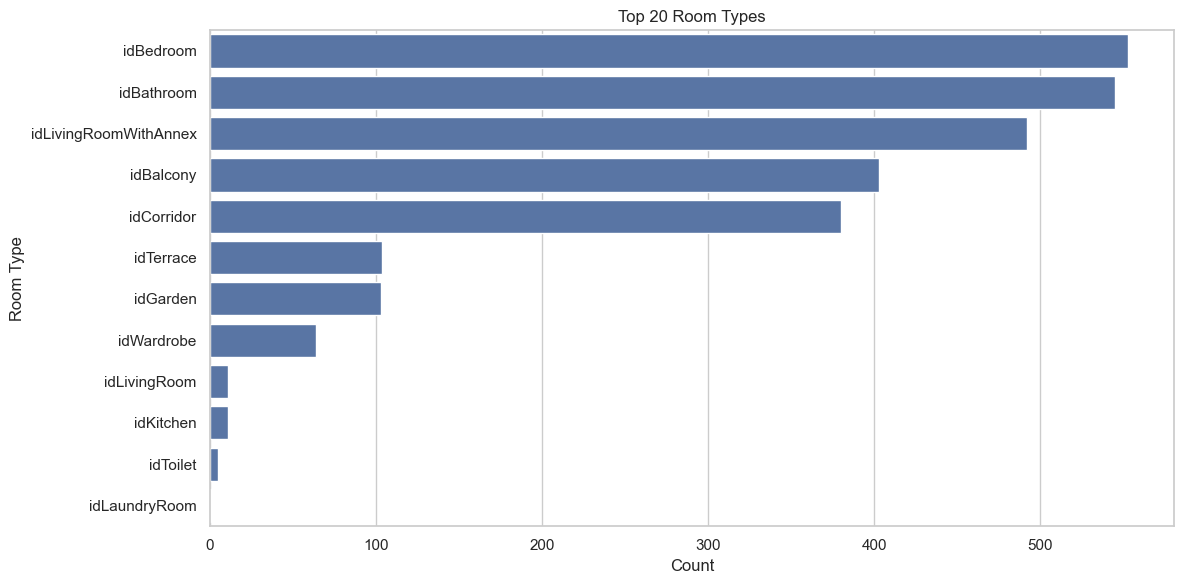

In [ ]:
room_types = Counter()
room_areas = defaultdict(list)

for json_file in json_files:
    apt_data = load_apartment_json(json_file)
    
    # for apt in apt_data.get("apartments", []):
    for comp in apt_data.get("compartments", []):
        room_type = comp.get("name_cad", "unknown")
        area = comp.get("area_orignal", 0.0)
        
        room_types[room_type] += 1
        room_areas[room_type].append(area)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
room_df = pd.DataFrame(room_types.most_common(20), columns=['Room Type', 'Count'])
sns.barplot(data=room_df, x='Count', y='Room Type', ax=ax)
ax.set_title('Top 20 Room Types')
plt.tight_layout()
plt.show()

## 4. Furniture ID Distribution

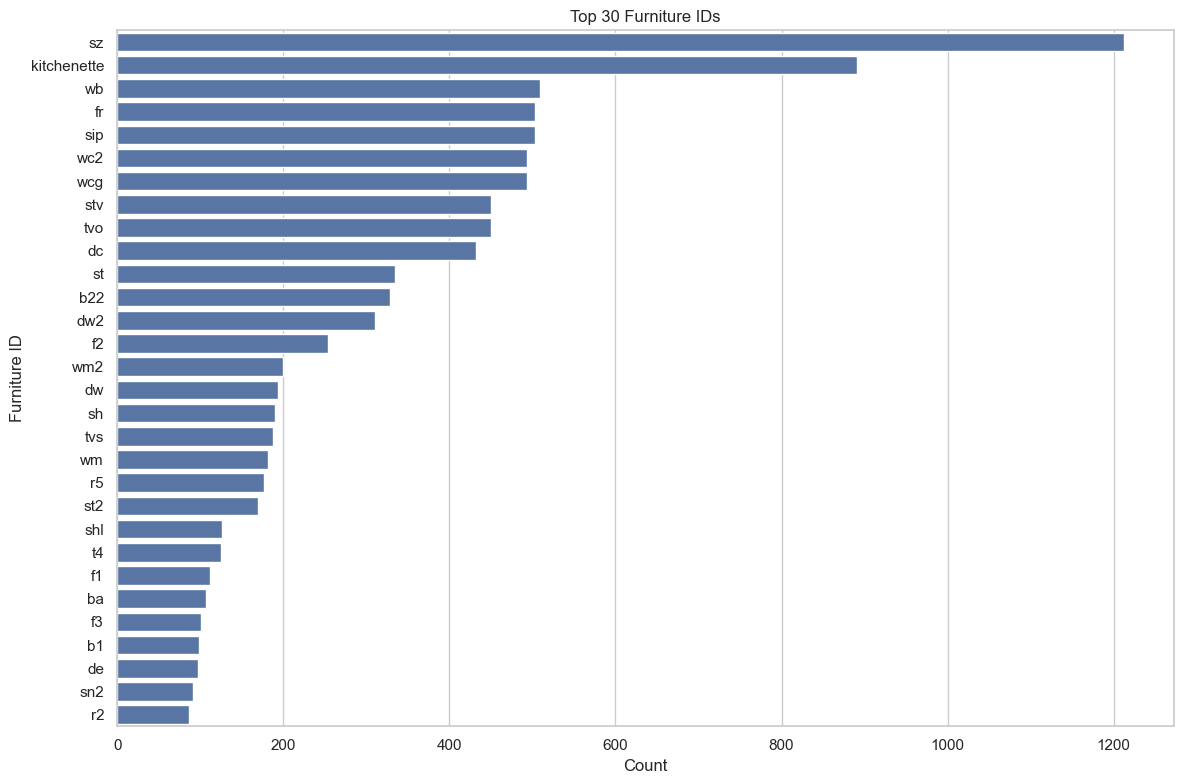


Total unique furniture IDs: 39


In [15]:
furniture_ids = Counter()
room_furniture_pairs = Counter()  # (room_type, furniture_id)

for json_file in json_files:
    apt_data = load_apartment_json(json_file)
    furniture_by_room = extract_furniture_ids(apt_data)
    
    for room_type, ids in furniture_by_room.items():
        for fid in ids:
            furniture_ids[fid] += 1
            room_furniture_pairs[(room_type, fid)] += 1

# Plot top furniture IDs
fig, ax = plt.subplots(figsize=(12, 8))
furn_df = pd.DataFrame(furniture_ids.most_common(30), columns=['Furniture ID', 'Count'])
sns.barplot(data=furn_df, x='Count', y='Furniture ID', ax=ax)
ax.set_title('Top 30 Furniture IDs')
plt.tight_layout()
plt.show()

print(f"\nTotal unique furniture IDs: {len(furniture_ids)}")

## 5. Semantic Validation

Check for suspicious room-furniture pairs

In [ ]:
# Define suspicious patterns (manual inspection needed)
# TODO: Update after seeing actual IDs
bathroom_furniture = ["sh", "wc", "sink", "bathtub"]  # Example IDs
bedroom_rooms = ["idBedroom", "idSypialnia"]  # Example room names

suspicious_pairs = []

for (room_type, furn_id), count in room_furniture_pairs.items():
    # Example: bathroom furniture in bedroom
    if any(br in room_type for br in bedroom_rooms) and furn_id in bathroom_furniture:
        suspicious_pairs.append((room_type, furn_id, count))

if suspicious_pairs:
    print("⚠️ Suspicious room-furniture pairs:")
    for room, furn, cnt in suspicious_pairs[:10]:
        print(f"  {room} + {furn}: {cnt} occurrences")
else:
    print("✅ No obvious semantic errors detected (or patterns not defined yet)")

## 6. Room Size Distribution by Type

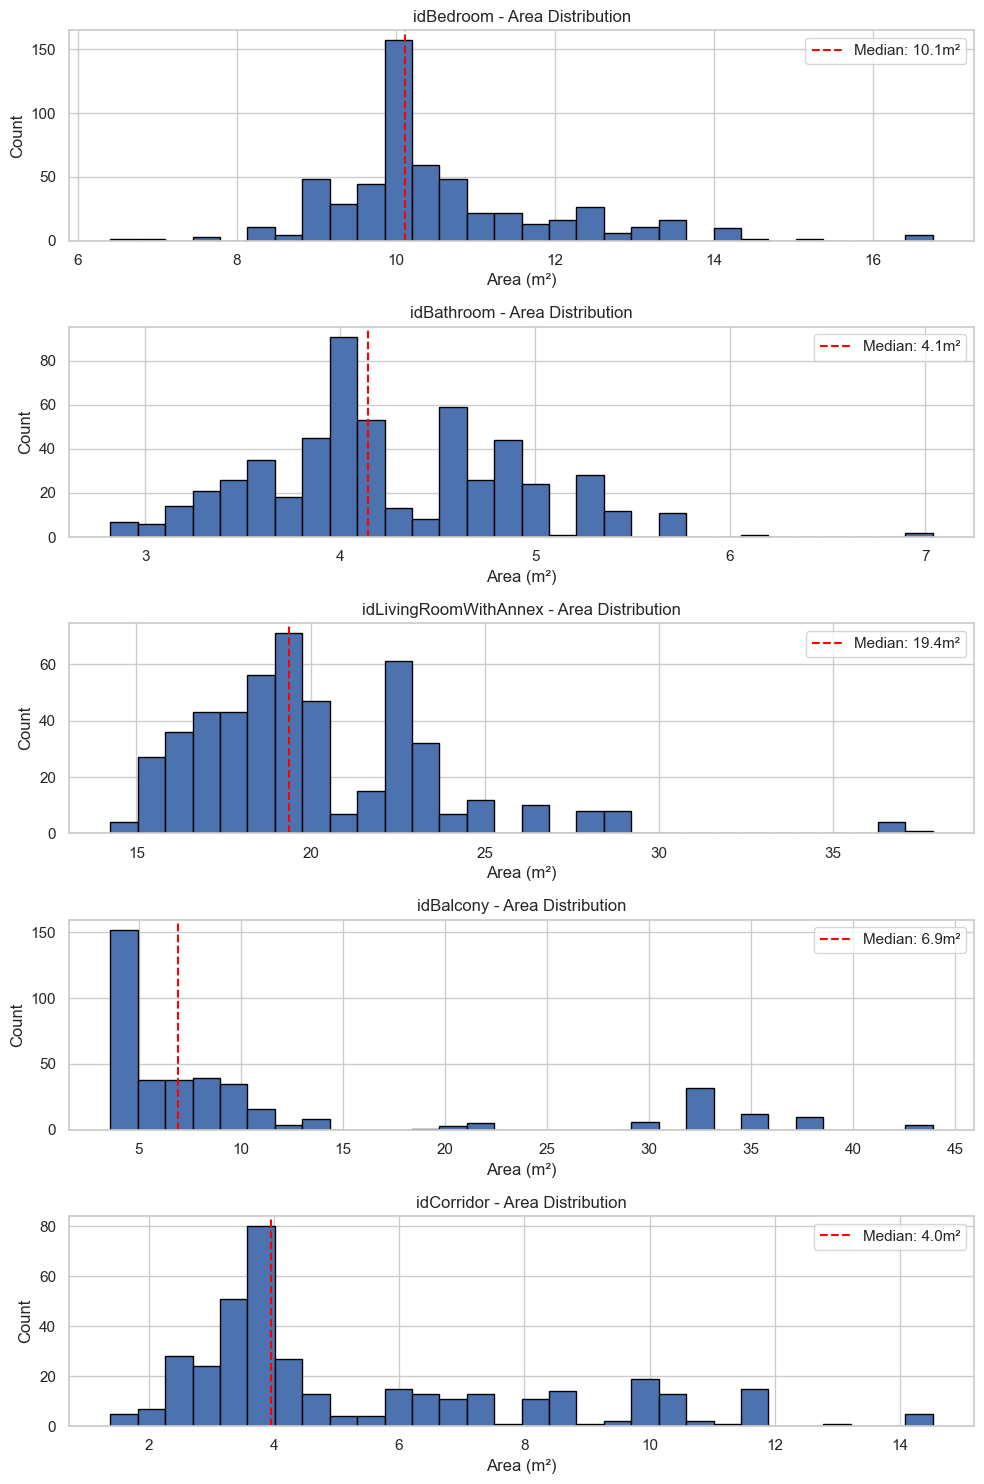

In [16]:
# Plot area distributions for common room types
top_rooms = [rt for rt, _ in room_types.most_common(5)]

fig, axes = plt.subplots(len(top_rooms), 1, figsize=(10, len(top_rooms) * 3))
if len(top_rooms) == 1:
    axes = [axes]

for idx, room_type in enumerate(top_rooms):
    areas = room_areas[room_type]
    axes[idx].hist(areas, bins=30, edgecolor='black')
    axes[idx].set_title(f'{room_type} - Area Distribution')
    axes[idx].set_xlabel('Area (m²)')
    axes[idx].set_ylabel('Count')
    axes[idx].axvline(np.median(areas), color='red', linestyle='--', 
                      label=f'Median: {np.median(areas):.1f}m²')
    axes[idx].legend()

plt.tight_layout()
plt.show()

## 7. Export Statistics for Pipeline Config

In [ ]:
stats = {
    "total_apartments_scanned": len(json_files),
    "apartments_with_furniture": apartments_with_furniture,
    "apartments_without_furniture": apartments_without_furniture,
    "unique_room_types": len(room_types),
    "unique_furniture_ids": len(furniture_ids),
    "top_room_types": dict(room_types.most_common(10)),
    "top_furniture_ids": dict(furniture_ids.most_common(20)),
    "avg_furniture_per_apartment": total_furniture_items / apartments_with_furniture if apartments_with_furniture > 0 else 0
}

# Save to configs
output_path = Path("../../datasets_pipelines/furniture_layouts_pipe/configs/eda_stats.json")
output_path.parent.mkdir(parents=True, exist_ok=True)
results_path = Path("../../datasets_pipelines/furniture_layouts_pipe/configs/eda_stats.json")
# results_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(stats, f, indent=2)
with open(results_path, 'w') as f:
    json.dump(stats, f, indent=2)

print(f"\n✅ Stats saved to {output_path} and {results_path}")
print(json.dumps(stats, indent=2))


✅ Stats saved to ..\..\datasets_pipelines\apartment_jsons_pipe\configs\eda_stats.json
{
  "total_apartments_scanned": 503,
  "apartments_with_furniture": 503,
  "apartments_without_furniture": 0,
  "unique_room_types": 12,
  "unique_furniture_ids": 39,
  "top_room_types": {
    "idBedroom": 553,
    "idBathroom": 545,
    "idLivingRoomWithAnnex": 492,
    "idBalcony": 403,
    "idCorridor": 380,
    "idTerrace": 104,
    "idGarden": 103,
    "idWardrobe": 64,
    "idLivingRoom": 11,
    "idKitchen": 11
  },
  "top_furniture_ids": {
    "sz": 1212,
    "kitchenette": 891,
    "wb": 509,
    "fr": 503,
    "sip": 503,
    "wc2": 493,
    "wcg": 493,
    "stv": 450,
    "tvo": 450,
    "dc": 432,
    "st": 334,
    "b22": 328,
    "dw2": 310,
    "f2": 254,
    "wm2": 200,
    "dw": 193,
    "sh": 190,
    "tvs": 187,
    "wm": 181,
    "r5": 177
  },
  "avg_furniture_per_apartment": 19.36779324055666
}


## Next Steps

Based on EDA results:
1. ✅ Identify all room types and furniture IDs
2. ✅ Check data quality (coverage, missing values)
3. 🔄 Create furniture catalog from SVG definitions
4. 🔄 Build data pipeline (1_collect → 2_validate → 3_process → 4_split)
5. 🔄 Start with Stage 1: Semantic model (room → furniture IDs)